In [87]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as topt
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

# torch distribs
import torch.distributions as dists

from neuralop.models import FNO

# <u>Experiments</u>

### 1. Gaussian Random Fields (GRF)

In [7]:
# Data

# GRF (TODO)
# Is it like Gaussian Processes? In the VANO paper, it just seems like functions where each f(x_i) is a Gaussian random variable, but they are linked so that it is "continuous"

/Users/sach/miniconda3/envs/deeplearning/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1699947508764/work/aten/src/ATen/native/TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


RuntimeError: Number of dimensions of repeat dims can not be smaller than number of dimensions of tensor

### 2. 2D Gaussian Densities

In [82]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=32, input_dim=2, output_dim=1, device='cpu'):
        super(Encoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.activ = nn.GELU()

        # Input: [output_dim, 48, 48]
        self.seq = nn.Sequential(
            nn.Conv2d(output_dim, 8, 2),        # [8, 47, 47]
            self.activ,
            nn.Conv2d(8, 16, 2),                # [16, 46, 46]
            self.activ,
            nn.MaxPool2d(2),                    # [16, 23, 23]
            nn.Conv2d(16, 32, 2),               # [32, 22, 22]
            self.activ,
            nn.Conv2d(32, 64, 2),               # [64, 21, 21]
            self.activ,
            nn.MaxPool2d(2),                    # [64, 10, 10]
            nn.Flatten(),                       # [64 * 10 * 10]
            nn.Linear(64 * 10 * 10, 256),       # [256]
            self.activ,
            nn.Linear(256, 128),                # [128]
            self.activ,
            nn.Linear(128, 2 * self.latent_dim) # [2 * latent_dim]
        )

    def forward(self, u):
        out = self.seq(u)
        mean = out[:, :self.latent_dim]
        logvar = out[:, self.latent_dim:]

        eps = torch.randn(u.shape[0], self.latent_dim, device=u.device)
        z = mean + eps * torch.exp(0.5 * logvar)

        return mean, logvar, z

class Decoder(nn.Module):
    def __init__(self, latent_dim=32, input_dim=2, output_dim=1, device='cpu'):
        super(Decoder, self).__init__()

        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.output_dim = output_dim

        # (original) NeRF-like architecture
        self.mlp_x = nn.Sequential(
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 32)
        )
        self.mlp_z = nn.Sequential(
            nn.Linear(self.latent_dim, 2 * self.latent_dim),
            nn.ReLU(),
            nn.Linear(2 * self.latent_dim, 2 * self.latent_dim),
            nn.ReLU(),
            nn.Linear(2 * self.latent_dim, 32)
        )
        self.joint_mlp = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x, z):
        """
        Computes u(x) by conditioning on z, a latent representation of u.

        Args:
            x: (batch_size, input_dim) tensor of spatial locations
            z: (batch_size, latent_dim) tensor of latent representations
        """
        x = self.mlp_x(x)
        z = self.mlp_z(z)
        # z is [32, 32], reshape to [32, 48, 48, 32]
        z = z.view(-1, 1, 1, 32).expand(-1, 48, 48, -1)
        xz = torch.cat([x, z], dim=-1)
        xz = self.joint_mlp(xz)

        return xz


class VANO(nn.Module):
    def __init__(self, latent_dim=32, input_dim=2, output_dim=1, device='cpu'):
        super(VANO, self).__init__()
    
        self.encoder = Encoder(latent_dim, input_dim, output_dim, device)
        self.decoder = Decoder(latent_dim, input_dim, output_dim, device)

        ls = torch.linspace(0, 1, 48).to(device)
        self.grid = torch.stack(torch.meshgrid(ls, ls), dim=-1).unsqueeze(0)

    def forward(self, u):
        z, mean, logvar = self.encoder(u)
        grids = self.grid.expand(u.shape[0], *self.grid.shape[1:])
        u_pred = self.decoder(grids, z)

        return mean, logvar, z, u_pred

In [12]:
enc = Encoder()

u = torch.randn(5, 1, 48, 48)

mean, logvar, z = enc(u)
print(z.shape, mean.shape, logvar.shape)

x = torch.rand(5, 2)
dec = Decoder()
out = dec(x, z)
print(out.shape)

torch.Size([5, 32]) torch.Size([5, 32]) torch.Size([5, 32])
torch.Size([5, 1])


Grid size torch.Size([2048, 48, 48, 2])
Function size torch.Size([2048, 48, 48])


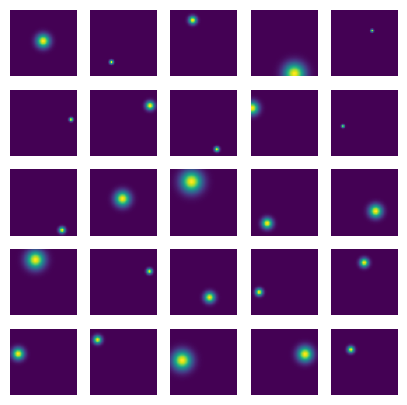

In [97]:
def gen_datasets(N=1, device='cpu'):
    """
    Creates N 2D gaussian pdfs.
    """
    mu_x = dists.Uniform(0, 1).sample((N,))
    mu_y = dists.Uniform(0, 1).sample((N,))

    # Std dev
    sigma = 0.01 + dists.Uniform(0, 0.1).sample((N,))
    
    dim_range = torch.linspace(0, 1, 48)
    grid = torch.stack(torch.meshgrid(dim_range, dim_range), dim=-1)

    x = torch.stack([grid] * N, dim=0)
    y = torch.stack([dists.MultivariateNormal(
        torch.tensor([mu_x[i], mu_y[i]]),
        covariance_matrix=(sigma[i]**2 * torch.eye(2))
        ).log_prob(grid) for i in range(N)], dim=0)

    return x.to(device), y.exp().to(device)

# Generate datasets
N_train = 2048
N_test = 32

train_data = gen_datasets(N_train, device='mps')
test_data = gen_datasets(N_test, device='mps')

train_dataset = torch.utils.data.TensorDataset(*train_data)
test_dataset = torch.utils.data.TensorDataset(*test_data)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Grid size", train_data[0].shape)
print("Function size", train_data[1].shape)

# Plot a grid with 10x10 sample functions
example_fcts = train_data[1][:100].reshape(10, 10, 48, 48).cpu().numpy()
grid_size = 5
fig, ax = plt.subplots(grid_size, grid_size, figsize=(grid_size, grid_size))
for i in range(grid_size):
    for j in range(grid_size):
        data = example_fcts[i, j]
        ax[i, j].imshow(data)
        ax[i, j].axis('off')
plt.show()

In [99]:
device = 'mps'

# Training
vano = VANO(device=device).to(device)
vano.train()

# Parameters:
S = 4  # Monte Carlo samples for evaluating reconstruction loss in ELBO (E_q(z | x) [log p(x | z)])
beta = 10e-5  # Weighting of KL divergence in ELBO
batch_size = 32
#num_iters = 20_000
num_iters = 500

# Exponential decay of every 1000 iterations by 0.9
lr = 1e-3
lr_decay = 0.9
lr_decay_every = 1000
optimizer = topt.Adam(vano.parameters(), lr=lr)
lr_scheduler = topt.lr_scheduler.StepLR(optimizer, step_size=lr_decay_every, gamma=lr_decay)

losses = []

step = 0
num_epochs = num_iters // len(train_loader)
for epoch in (epoch_bar := tqdm(range(num_epochs), position=0, leave=True, desc="Epochs")):
    epoch_bar.set_description(f"Epoch {epoch}")
    for grid, u in (iter_bar := tqdm(train_loader, position=1, leave=False)):
        iter_bar.set_description(f"Step {step}")

        #grid, u = grid.to(device), u.to(device)
        
        mu, logvar, z, u_hat = vano(u.view(-1, 1, 48, 48))
        u_hat = u_hat.squeeze()

        u, u_hat = u.flatten(1), u_hat.flatten(1)

        # ELBO = E_p(eps)[log p(x | z=g(eps, x))] - KL(q(z | x) || p(z))
        loss = F.mse_loss(u_hat, u, reduction='none').sum(axis=1).mean()
        loss += beta * (0.5 * (mu ** 2 + logvar.exp() - logvar - 1).sum(axis=1).mean())
        
        optimizer.zero_grad()
        loss.backward()            
        optimizer.step()
        
        losses.append(loss.item())
        
        if step % 1000 == 0:
            lr_scheduler.step()

        step += 1

plt.plot(losses)
plt.show()

Epochs:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 3. Phase Separation in Cahn-Hilliard Systems

## 4. Interferometric Synthetic Aperture Radar